# Import mosaic and pytorch libraries

In [ ]:
from mosaicml import *
from mosaicml.constants import MLModelFlavours
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cloudpickle
from werkzeug.datastructures import FileStorage
from PIL import Image
import requests

# Loading and normalizing CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# showing some of the training images

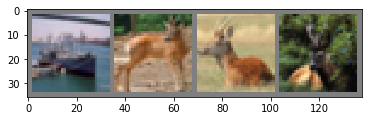

 ship  deer  deer  deer


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define a Convolutional Neural Network

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
model = MyModel()
model

MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Define a Loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the network

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.180
[1,  4000] loss: 1.894
[1,  6000] loss: 1.685
[1,  8000] loss: 1.578
[1, 10000] loss: 1.516
[1, 12000] loss: 1.457
[2,  2000] loss: 1.407
[2,  4000] loss: 1.365
[2,  6000] loss: 1.327
[2,  8000] loss: 1.314
[2, 10000] loss: 1.308
[2, 12000] loss: 1.273
Finished Training


# Test the data on test data

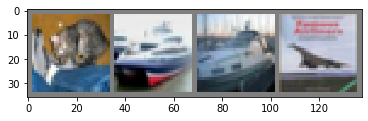

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane  ship plane


# Accuracy on whole dataset

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


# Define scoring function using `scoring_func` decorator

In [11]:
@scoring_func
def score(model, request):
    file= FileStorage(request.files['file1'])
    file.save("f1.jpg")
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    data = transform(Image.open("f1.jpg"))
    image = data.unsqueeze(0)
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    return ('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

# creating payload to test scoring function

In [12]:
request = requests.Request()
request.files= {"file1" : open('cat.jpg','rb')}
s=score(model,request)
s

('Predicted: ', '  dog')

# Register neural network to mosaic

In [15]:
register_model(model, score, "torch_cd_pickle", "convolutional NN using pytorch", MLModelFlavours.pytorch)

{'created_by': 'akhil.lawrence',
 'created_on': '2019-09-27T09:46:06+00:00',
 'description': 'convolutional NN using pytorch',
 'flavour': 'pytorch',
 'id': '1cca3b47-5d99-4eaf-9423-7c8c9ebc1268',
 'init_script': '',
 'last_modified_by': 'akhil.lawrence',
 'last_modified_on': '2019-09-27T09:46:06+00:00',
 'name': 'torch_cd_pickle',
 'project_id': '1',
 'versions': [{'created_by': 'akhil.lawrence',
   'created_on': '2019-09-27T09:46:06+00:00',
   'deployments': [],
   'description': None,
   'id': '1ed0a290-f863-4619-ab0c-71df8ded0da3',
   'last_modified_by': 'akhil.lawrence',
   'last_modified_on': '2019-09-27T09:46:07+00:00',
   'ml_model_id': '1cca3b47-5d99-4eaf-9423-7c8c9ebc1268',
   'object_url': '1cca3b47-5d99-4eaf-9423-7c8c9ebc1268/1ed0a290-f863-4619-ab0c-71df8ded0da3/ml_model.tar.gz',
   'profiling': [],
   'schema': None}]}

# Load model back from mosaic

In [ ]:
load_model("1cca3b47-5d99-4eaf-9423-7c8c9ebc1268", "1ed0a290-f863-4619-ab0c-71df8ded0da3")